# Calibrate

Either copy camera transformations from another location or perform calibration here

In [1]:
PARAMS = {
    'session_name':'calibration',
    'working_directory':'long_pairs',
    'copy_from_other_directory':'',
    'reference_camera':'739112060301',
    'depth_near_clipping':300
}

In [2]:
import shutil, json, os, sys, time, pickle, h5py, cv2, numpy as np, matplotlib.pyplot as plt
from MoseqMulti_calibrate import *
from MoseqMulti_utils import *
%matplotlib inline

Calculating camera transforms
Detecting keypoints for camera 816312062021
Frame 0 out of < 3136
Frame 100 out of < 3136
Frame 200 out of < 3136
Frame 300 out of < 3136
Frame 400 out of < 3136
Frame 500 out of < 3136
Frame 600 out of < 3136
Frame 700 out of < 3136
Frame 800 out of < 3136
Frame 900 out of < 3136
Frame 1000 out of < 3136
Frame 1100 out of < 3136
Frame 1200 out of < 3136
Frame 1300 out of < 3136
Frame 1400 out of < 3136
Frame 1500 out of < 3136
Frame 1600 out of < 3136
Frame 1700 out of < 3136
Frame 1800 out of < 3136
Frame 1900 out of < 3136
Frame 2000 out of < 3136
Frame 2100 out of < 3136
Frame 2200 out of < 3136
Frame 2300 out of < 3136
Frame 2400 out of < 3136
Frame 2500 out of < 3136
Frame 2600 out of < 3136
Frame 2700 out of < 3136
Frame 2800 out of < 3136
Frame 2900 out of < 3136
Detecting keypoints for camera 816312062005
Frame 0 out of < 3136
Frame 100 out of < 3136
Frame 200 out of < 3136
Frame 300 out of < 3136
Frame 400 out of < 3136
Frame 500 out of < 3136
Fr

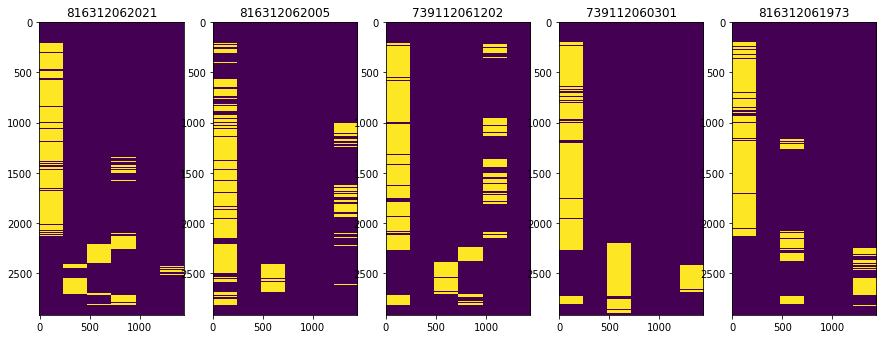

In [3]:
if len(PARAMS['copy_from_other_directory']) > 0:
    print('Copying camera transforms from '+ PARAMS['copy_from_other_directory'])
    os.system('cp '+PARAMS['copy_from_other_directory']+'/transforms.p '+PARAMS['working_directory']+'/')
    
else:
    print('Calculating camera transforms')
    path_prefix = PARAMS['working_directory']+'/data/'+PARAMS['session_name']
    metadata = json.load(open(path_prefix+'_metadata.json'))
    readers = get_video_readers(path_prefix, metadata, PARAMS)
    transforms = get_transforms(readers, metadata, PARAMS)
    pickle.dump(transforms, open(PARAMS['working_directory']+'/transforms.p','wb'))

### ~~ This part is under construction ~~ ###

In [5]:
from pyntcloud import PyntCloud
import pandas as pd

n = 'two_males_v1'
path_prefix = PARAMS['working_directory']+'/data/'+n
metadata = json.load(open(path_prefix+'_metadata.json'))
readers = get_video_readers(path_prefix, metadata, PARAMS)
transforms = pickle.load(open(PARAMS['working_directory']+'/transforms.p','rb'))

In [8]:

run_ahead = 10
serial_numbers = metadata['serial_numbers']

colors = []
positions = []
for ii,sn in enumerate(serial_numbers):
    for _ in range(run_ahead): color_im, depth_im = next(readers[sn])
        
    X,Y = np.meshgrid(np.arange(color_im.shape[1]),np.arange(color_im.shape[0]))
    pixel = np.vstack((X.flatten(),Y.flatten())).T
    depth = depth_im.flatten()
    ff = depth < 1000
    pp = deproject(pixel[ff,:],depth[ff], metadata['intrinsics'][sn])
    R,t = transforms[sn]
    pp = pp.dot(R.T) + t
    positions.append(pp)
    cc = color_im.reshape(color_im.shape[0]*color_im.shape[1],3)[ff,:]
    #cc = cc * .8
    #cc = np.minimum(cc +np.repeat(np.array(plt.cm.jet(ii/len(serial_numbers))[:3])[None,:]*60,cc.shape[0],axis=0),255)
    colors.append(cc)
colors = np.vstack(colors)[:,::-1]
positions = np.vstack(positions)

cube_centroid = positions.mean(0)
dist = np.sqrt(((positions-cube_centroid)**2).sum(1))
ff = dist < 150
positions = positions[ff,:]
colors = colors[ff] #,:]

positions[:,2] = -positions[:,2]
points = pd.DataFrame(
    positions.astype(np.float32), 
    columns=['x', 'y', 'z'])
points['red']=colors[:,0].astype(np.uint8)
points['blue']=colors[:,2].astype(np.uint8)
points['green']=colors[:,1].astype(np.uint8)

cloud = PyntCloud(points)
cloud.plot(initial_point_size=6)

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(23.83270263671875, 97.24309539794922, 102.21…

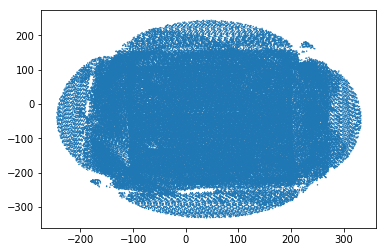

In [30]:
plt.scatter(positions[::10,0],positions[::10,1], s=2, edgecolor='')

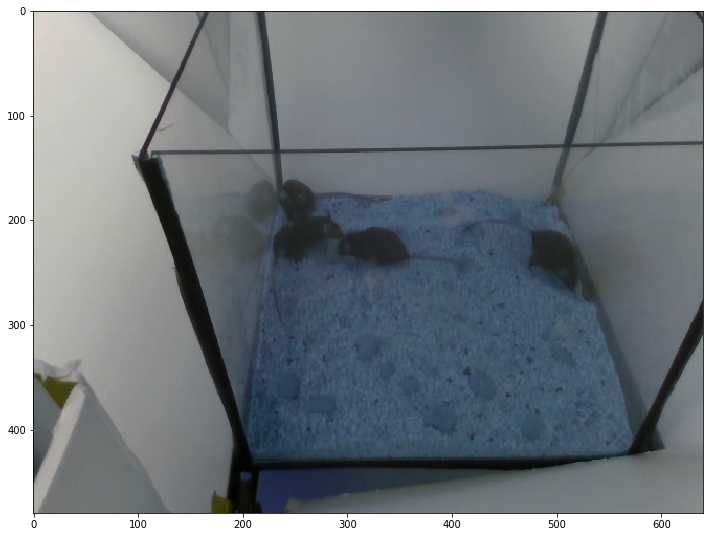

In [14]:
plt.imshow(data[metadata['serial_numbers'][0]]['color'][2100,:,:,:])
plt.gcf().set_size_inches((12,12))
plt.savefig('/home/dattalab/Desktop/test1.png')